# Computational Intelligence CI2024_lab2
> - Author: Daniel Bologna
> - ID: 310582

## The Traveling Salesman Problem
- [Travelling salesman problem - Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

### Import libraries

In [17]:
import logging
from itertools import combinations # Return r length subsequences of elements from the input iterable.
import pandas as pd
import numpy as np
from geopy.distance import geodesic ## compute distance between points
import networkx as nx
import matplotlib.pyplot as plt

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

### Load Cities

In [18]:
def _load_cities(city_name : str) -> tuple[pd.DataFrame, np.ndarray]:
    """Loads TSP cities from CSV file.
    Args:
        city_file_path (str): The name of the city.
    Returns:
        tuple[pd.DataFrame, np.ndarray]
    """
    CITIES = pd.read_csv(f'cities/{city_name}.csv', header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    return CITIES, DIST_MATRIX

def _to_pandas_table(matrix, x_names=None, y_names=None):
    """Returns a dataframe from a matrix"""
    return pd.DataFrame(matrix, index=x_names, columns=y_names)

In [19]:
city_name = "vanuatu"
CITIES, DIST_MATRIX = _load_cities(city_name)
CITIES.head(10)

,name,lat,lon
0,Isangel,-19.53,169.28
1,Lakatoro,-16.09,167.40
2,Longana,-15.30,168.00
3,Luganville,-15.51,167.15
4,Norsup,-16.07,167.39
5,Port Olry,-15.05,167.05
6,Sola,-13.87,167.55
7,Vila,-17.74,168.31


In [20]:
_to_pandas_table(DIST_MATRIX, [str(_) for _ in CITIES['name']], [str(_) for _ in CITIES['name']])

,Isangel,Lakatoro,Longana,Luganville,Norsup,Port Olry,Sola,Vila
Isangel,0.000000,429.730587,487.494509,499.078125,432.187932,549.553211,652.957466,223.004751
Lakatoro,429.730587,0.000000,108.528818,69.545768,2.458238,121.048804,246.169150,206.739997
Longana,487.494509,108.528818,0.000000,94.155879,107.405375,105.770636,165.485112,272.040791
Luganville,499.078125,69.545768,94.155879,0.000000,67.091296,52.020596,186.502725,276.075871
Norsup,432.187932,2.458238,107.405375,67.091296,0.000000,118.613114,244.034302,209.196708
Port Olry,549.553211,121.048804,105.770636,52.020596,118.613114,0.000000,141.250458,326.691023
Sola,652.957466,246.169150,165.485112,186.502725,244.034302,141.250458,0.000000,435.911385
Vila,223.004751,206.739997,272.040791,276.075871,209.196708,326.691023,435.911385,0.000000


In [21]:
def tsp_cost(tsp : np.ndarray) -> float:
    """Compute the cost of the path as the sum of the cities' distances."""
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0.0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

# Visualization

Simple function that plot a graph

In [22]:
def _print_graph(solution, points=True, lines=True, p_color = "red", l_color = "red", title=""):
    """Plot the graph from a coordinate matrix"""
    coord = [
        [CITIES.at[i, "lon"] for i in solution],
        [CITIES.at[i, "lat"] for i in solution]
    ]
    plt.axis("off")
    plt.title(title)
    if points: plt.scatter( coord[0], coord[1], color=p_color)
    if lines: plt.plot( coord[0], coord[1], color=l_color)
    plt.show()

# Nearest Neighbor approach

> Start from a point, then choose the nearest point in the list of cities. Repeat until completion. 

ic| final_cost: '1475.528091104531 km'


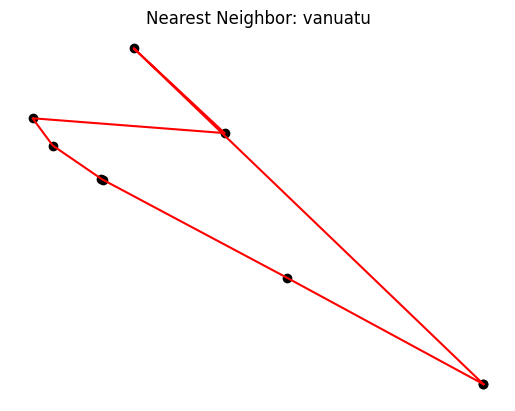

In [23]:
def _nn_approach(cities, dist_mat):
    visited = np.full(len(cities), False)
    dist = dist_mat.copy()

    # Choose a random city to start
    city = np.random.randint(0, len(cities))

    # Create a solution as a list of integers (city's index)
    tsp_sol = list()

    # Append the first city to the solution and mark as visited
    tsp_sol.append(int(city))
    visited[city] = True

    while not np.all(visited):
        # Set the city's column as inf distance to avoid 
        # calculating the distance between a city and itself
        dist[:, city] = np.inf

        # Find the closest city
        closest = np.argmin(dist[city])

        # Mark it as visited, push it to the solution and se the current city as the closest
        visited[closest] = True
        city = closest
        tsp_sol.append(int(city))

    # In the end add the first city at the end to create a cycle
    tsp_sol.append(int(tsp_sol[0]))
    return (tsp_sol, tsp_cost(tsp_sol))

EPOCHS = 1000
tsp_sol, cost = _nn_approach(CITIES, DIST_MATRIX)
for i in range(EPOCHS):
    new_tsp_sol, new_cost = _nn_approach(CITIES, DIST_MATRIX)
    if new_cost < cost:
        tsp_sol = new_tsp_sol
        cost = new_cost

# Print the result and plot the graph
final_cost = f"{cost} km"
ic(final_cost)
_print_graph(tsp_sol, p_color="black", title=f"Nearest Neighbor: {city_name}")

# EA approach